# Machine Learning in Crowd Modelling and Simulation

## Group: M
1. Muhammad Waleed Bin Khalid
2. Qais Hamarneh
3. Yiming Zhang

We implement a crowd simulation model using the cellular automata approach.
Our implementation can be run either by loading saved scenario files which are based on csv files or by the user detailing their own scenario.

Before moving ahead we import the key packages. It is best to install the required packages as detailed in the
`README.md` file with the help of the provided `requirements.txt` file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from utilities import parser_array2obj, execute_rimea_4
from visualization import visualize_state
from main import crowd_simulator
from game_gui import start_game_gui
from pathlib import Path
import pandas as pd
import os 
from shutil import copyfile

%reload_ext autoreload
%autoreload 2
%matplotlib notebook

pygame 2.0.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Some conventions
Throughout this notebook and in the simulations we will follow some labelling conventions for clarity. These are listen in the table below:

|Numerical Encoding|Description|Color Assignment in GUI and visualizations| |
|---|---|---|---|
|0|Empty Cell| <span style="color:blue">Blue</span>.  ||
|1|Pedestrian|  <span style="color:red">Red</span>. | |
|2|Obstacle| <span style="color:yellow">Yellow</span>.  |   |
|3|Target|  <span style="color:green">Green</span>. ||


# Task 1: The setup

It is possible to execute the crowd simulator in two ways. The first is to simply execute the `main.py` file i.e. `python3 main.py` and then following the instructions on the CLI. The second method is to execute it by calling the appropriate function and methods in the jupyter notebook environment. In order to show the functionality of the simulator, we will first make use of the pygame GUI. In subsequent tasks, since we wish to show states and specific plots, we will use the jupyter notebook environment to run the simulations.

Here the user has two options

### Option 1: Load scenario
Some scenarios are already saved in the `scenarios` directory. These are simple csv files which follow the encoding described above and are read by the a `scenario_loader` function.

If you wish to load a scenario then type y in the following cell block. A list of available scenarios will be printed. Enter the id number of the scenario you wish to load and this will be loaded into a variable.

Please note that for the presaved scenario, the cell size have been scaled. This scaling is defined in the table below:

|Scenario |Length of one cell in meters| |
|---|---|---|
|task_2.csv|1| |
|task_3.csv|1|  |
|task_4.csv|1|    |
|Chicken Test|1|  |
|RiMEA 1|0.4|  |
|RiMEA 4|0.33|  |
|RiMEA 6|0.5|  |
|RiMEA 7|1|  |

### Option 2: Make custom scenario
If you wish to make own scenario then type n in the following cell block. You will be asked for the size of the grid you wish to generate, the size of the cell you wish to keep and the number of moves you wish to simulate. Finally a GUI will pop up. You can make a scenario there. Clicking on the `start` or `pause` buttons, as their name suggests would flip a `simulation_running` flag to start, pause or resume the simulation. Clicks on the grid cells, before the simulation starts, changes the type of the cell in this order:

Empty → Pedestrian → Obstacle → Target


In [ ]:
crowd_simulator()

# Task 2: Single Pedestrian

### The simulation
We will now simulate the loaded scenario with our simple update step that uses the distance to the target as the cost function. The scenario is such that we have a grid of 50x50 cells and a pedestrian at position (5,25) and a target at (25,25). Let us see how the pedestrian progresses.

**NOTE: This simulation can also be executed using the pygame GUI. Simply select load scenario and select the task_1.csv scenario file.**

The results will be visualized with the help of a matplotlib animation. The initial state of the scenario is shown below:

<IPython.core.display.Javascript object>


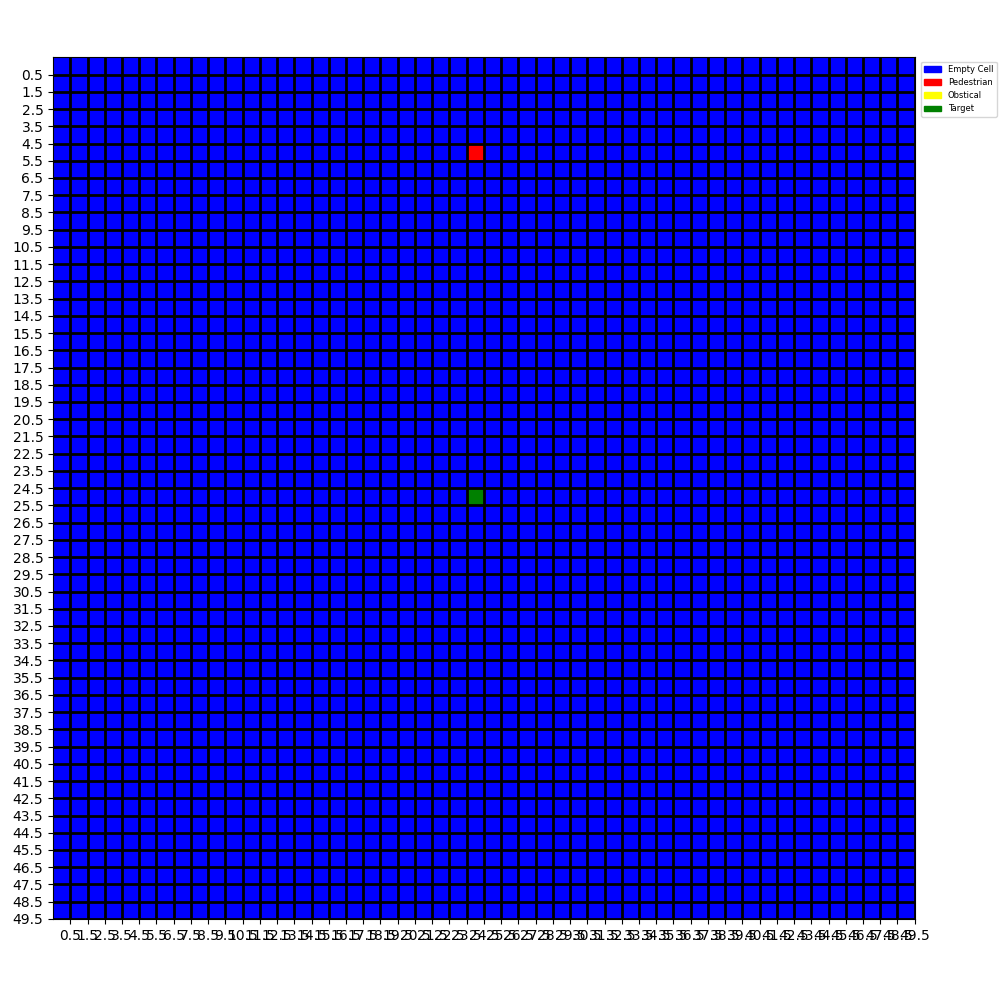

In [2]:
with open('./scenarios/task_2.csv', newline='') as csvfile:
    task_2 = np.array(list(csv.reader(csvfile))).astype(int)
    task_2 = parser_array2obj(task_2)
visualize_state(task_2.to_array())

**Let us simulate this for 25 steps and animate**

We execute the simulation and see that the pedestrian reaches the target in 20 steps.


In [ ]:
task_2.simulate(25)
task_2.animate()

### Observations

We use the simple utility of how close the cell is to the target which can be visualized with the aid of a color map as depicted. We see that indeed the distance to target increases radially since the diagonal distance is larger than the straight line distance which can be seen by concentric circular contours.

The simulation was took 2 steps and was executed in 0.6 seconds.


<IPython.core.display.Javascript object>


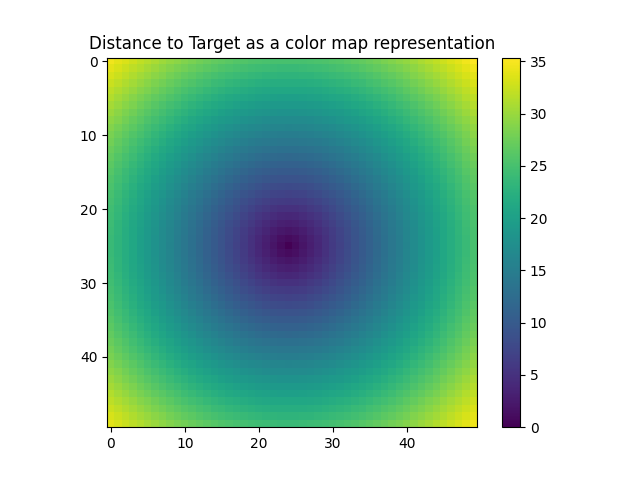

Text(0.5, 1.0, 'Distance to Target as a color map representation')

In [3]:
task_2.simulate(1)
fig = plt.figure()
cost_task_2 = task_2.get_distance_to_target()
plt.imshow(cost_task_2)
plt.colorbar()
plt.title("Distance to Target as a color map representation")

# Task 3: Pedestrian Interaction

### Pedestrian Repulsion Function 

In this task we will show how pedestrians interact with each other in a  given scenario.
In order to model the pedestrian interaction we use the following formula for modelling repulsion:

### cost = $\frac{1}{exp(r^2 - r_{max}^2)}$

This way r_max becomes a parameter that can be adjusted to model the pedestrian repulsion behavior. If r_max is too large then the pedestrians will maintain larger and larger distances amongst themselves, something that might be useful if we with to model for example social distancing. However, if r_max is small and rather close to 1 then the pedestrians will get closer and closer to one another (but never step on one another) in the event of congestions.


<IPython.core.display.Javascript object>


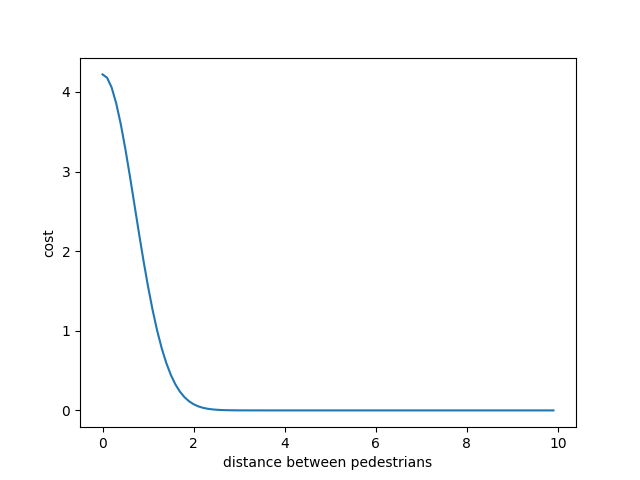

In [5]:
x = np.arange(0,10,0.1)
y = 1/np.exp(x**2 - 1.2**2)
fig, ax = plt.subplots(1,1)
ax.plot(x,y)
ax.set_ylabel('cost')
ax.set_xlabel('distance between pedestrians')
plt.show()

## Pedestrian Interaction Experiment

In order to observe pedestrian interactions, we recreate the same scenario as in Task 2, however, this time we have 5 pedestrians arranged in a circle at equal distances to the target at the center. Since the pedestrians have the same speed and are equidistant, we expect them to reach the target at roughly the same time. 

<IPython.core.display.Javascript object>


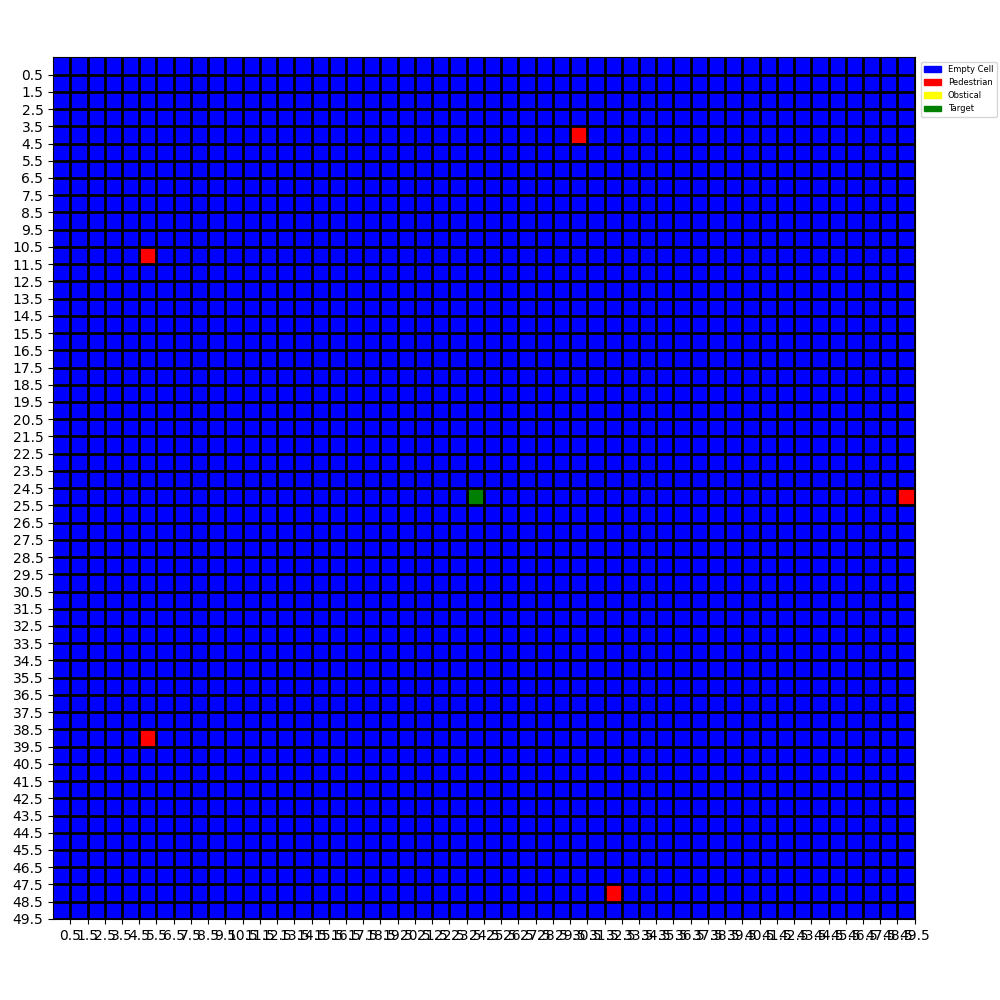

In [6]:
with open('./scenarios/task_3.csv', newline='') as csvfile:
    task_3 = np.array(list(csv.reader(csvfile))).astype(int)
    task_3 = parser_array2obj(task_3)
visualize_state(task_3.to_array())

In [ ]:
task_3.simulate(50)
task_3.animate()

# Task 4: Obstacle Avoidance 

### Without Obstacle Avoidance

We see that as expected, without obstacle avoidance, the pedestrians simply break the obstacle barrier and go through it. This is ofcourse not natural behavior (unless the pedestrians are really strong ;-) ) Hence we will apply some basic obstacle avoidance.

Before we do that we observe what happens in the bottleneck scenario if there is no obstacle avoidance.

<IPython.core.display.Javascript object>


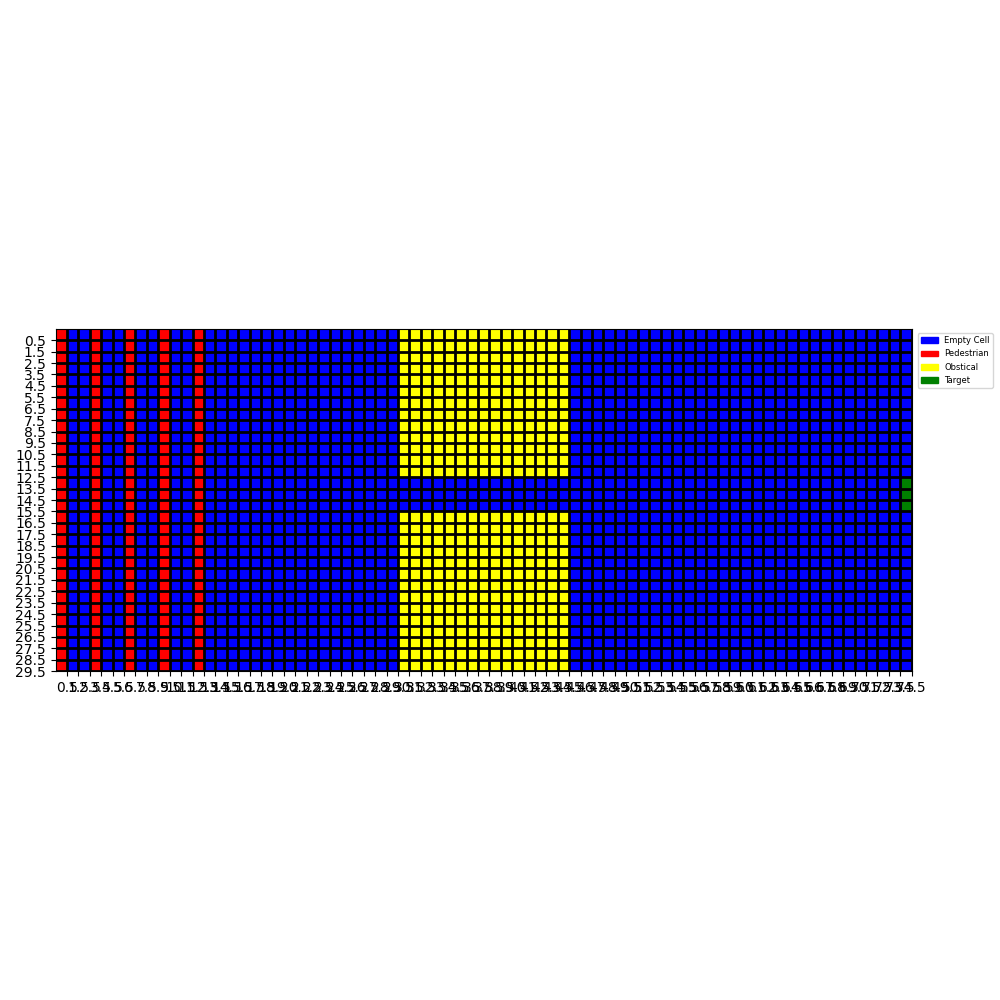

In [7]:
with open('./scenarios/task_4.csv', newline='') as csvfile:
    task_4 = np.array(list(csv.reader(csvfile))).astype(int)
    task_4 = parser_array2obj(task_4, obstacle_avoidance=False)
visualize_state(task_4.to_array())

In [ ]:
task_4.simulate(60, obstacle_avoidance=False)
task_4.animate()

### Rudementary Obstacle Avoidance

We have now implemented some basic obstacle avoidance which is as simple as setting a rule that pedestrians should not step into a cell that is classified as an obstacle. This is done by assigning the obstacle cells with a very high cost. Now the pedestrians cannot pass through obstacles and in the worst case will have to stay at their previous position if there are no other viable cells where they can move.

We can observe that now the pedestrians follow a more "Natural" behavior and do not barge through obstacles as they did before.

<IPython.core.display.Javascript object>


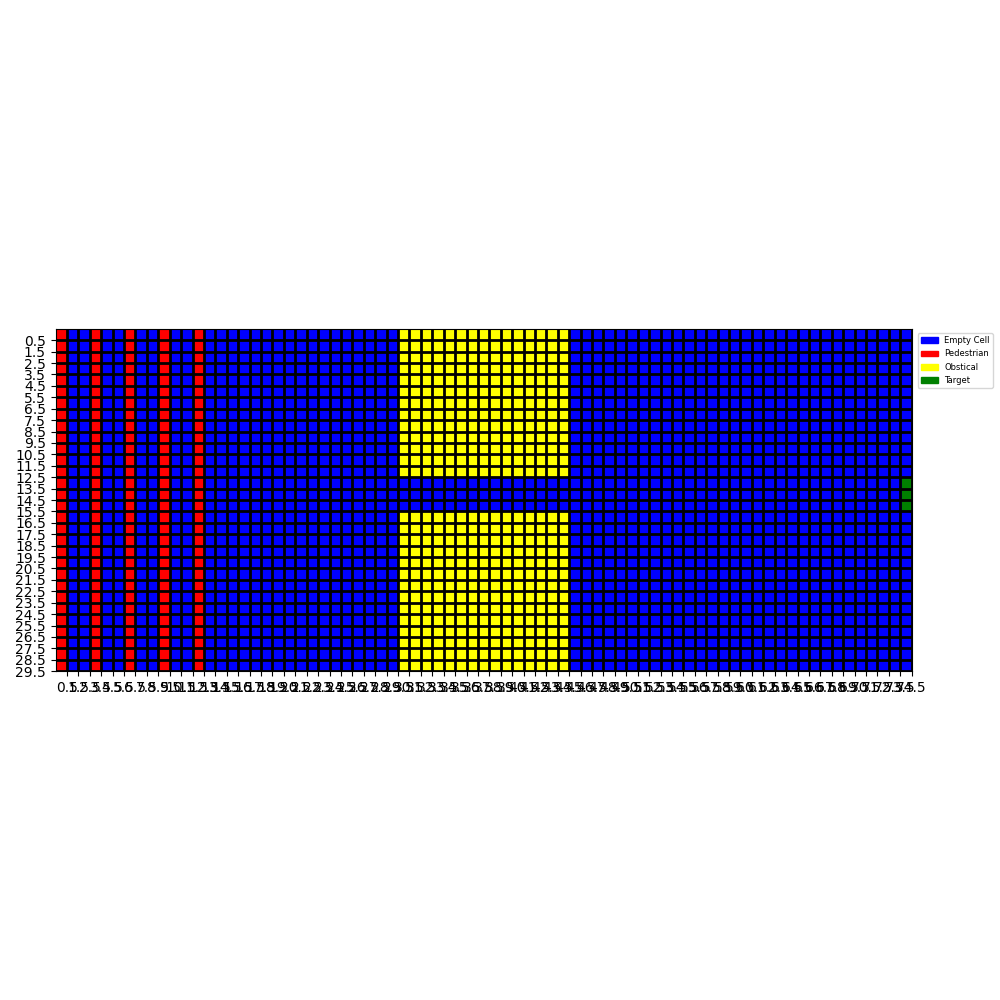

In [8]:
with open('./scenarios/task_4.csv', newline='') as csvfile:
    task_4 = np.array(list(csv.reader(csvfile))).astype(int)
    task_4 = parser_array2obj(task_4)
visualize_state(task_4.to_array())

In [ ]:
task_4.simulate(60, dijkstra=True)
task_4.animate()

### The Chicken Test
Rudementary obstacle avoidance implemented, we see how our simulator now performs on the chicken test with 1 pedestrian only.

<IPython.core.display.Javascript object>


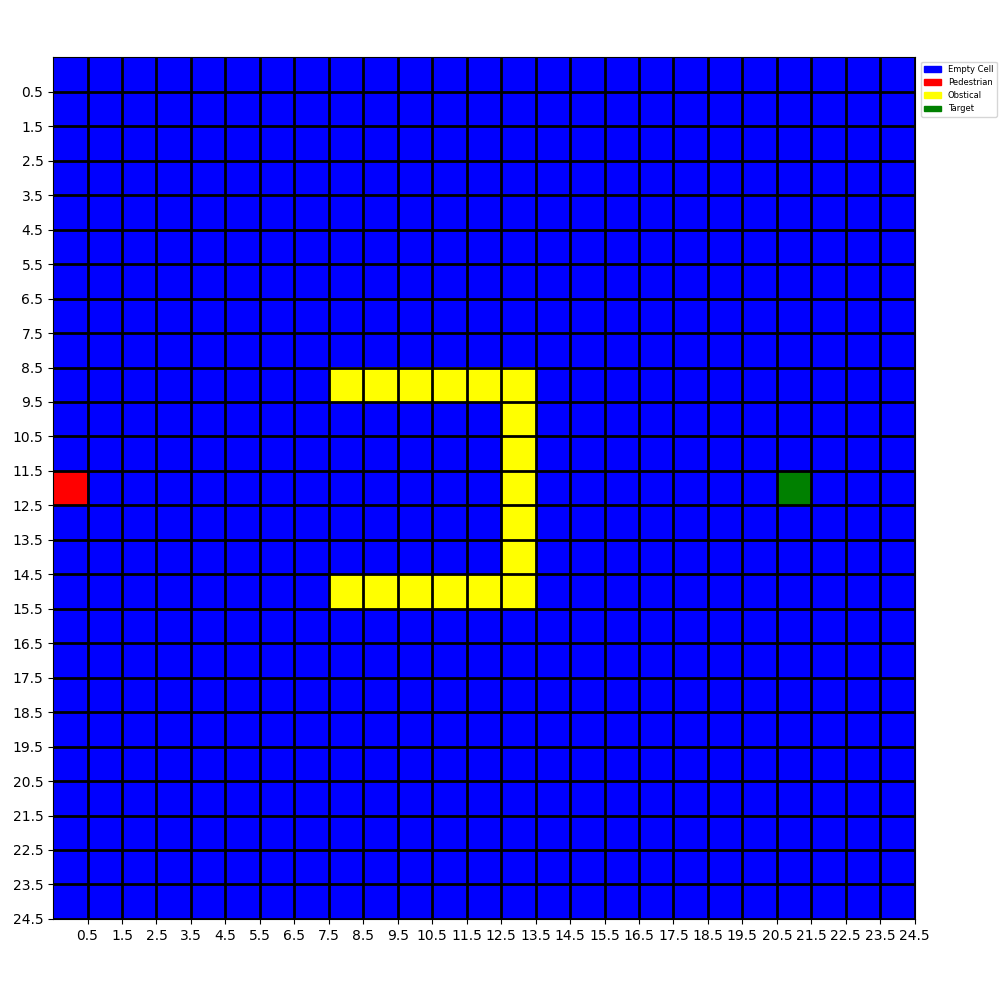

In [9]:
with open('./scenarios/chicken_test.csv', newline='') as csvfile:
    chicken_test = np.array(list(csv.reader(csvfile))).astype(int)
    chicken_test = parser_array2obj(chicken_test)
visualize_state(chicken_test.to_array())

**As expected, our poor pedestrian gets stuck in the trap because the cells simply have a cost which does not take into account how paths are connected.**

In [ ]:
chicken_test.simulate(25, dijkstra=False)
chicken_test.animate()

### The Dijkstra's Algorithm
We implement the Dijkstra's algorithm to flood the cells with utilitiy values starting from the targets i.e. targets have a cost of 0. 

This allows a kind of look ahead when we simulate our pedestrians since now we have also taken into account the obsticals. Essentially the entire grid is treated as an undirected graph instead of the points where the obsticals exist. These cells are treated as unconnected nodes on the graph. This is shown below:

<table>
  <tr>
    <td><img src="./figures/fully_connected.jpg" width=270 height=480></td>
    <td><img src="./figures/graph_with_obj.jpg" width=270 height=480></td>
  </tr>
      <tr>
    <td>Fully Connected Bi-Directional Graph</td>
     <td>Bi-directional Graph with Obstacle </td>
  </tr>
 </table>
 
When the Dijkstra's algorithm starts, it picks the cells with the lowest cost which are naturally the targets and from there on computes the cost which is simply the distance of the cells. Note that the diagonal distance is different from the straight line difference. Executing the algorithm, we can flood the cost values.

### Chicken Test Part 2: The dijkstra's algorithm
We now plot the cell costs that are calculated with the help of the dijkstra's algorithm with the target cell(s) having a cost of 0. This is represented in the color map of the chicken test below.

We can see the the trap at the middle has a high cost as visible in the color map meaning the pedestrians will automatically avoid going into the trap due to the high cost attached to it.

<IPython.core.display.Javascript object>


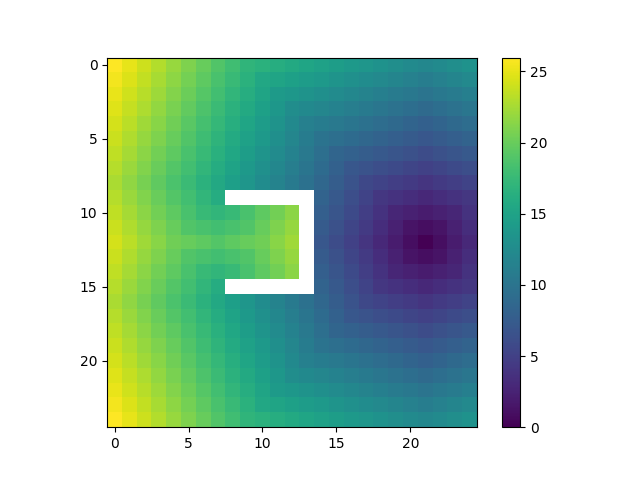

The simulation was took 2 steps and was executed in 0.6 seconds.


In [10]:
with open('./scenarios/chicken_test.csv', newline='') as csvfile:
    chicken_test = np.array(list(csv.reader(csvfile))).astype(int)
    chicken_test = parser_array2obj(chicken_test)

fig = plt.figure()
chicken_test.simulate(1, dijkstra=True)
plt.imshow(chicken_test.get_dijkstra())
plt.colorbar()

Let us now simulate the chicken test again this time with the dikstra's algorithm. We can observe that as predicted before, because of the proper filling of the costs by the dijkstra's algorithm the pedestrian indeed knows that they must avoid the trap at the center because otherwise the connected graph would produce an excessively long way to the destination.


In [ ]:
chicken_test.simulate(25, dijkstra=True)
chicken_test.animate()

# Task 5: Integration Testing - RiMEA Scenarios

We now test our crowd simulation software with the help of the RiMEA guidelines.


### RiMEA 1
In this test we need to assess if the speed at which a certain pedestrian walks towards the target translates to an accurate simulation time. the scenario is a 40m by 10m corridor. We model each cell as 0.4m and the pedestrian as 0.4m as well so that the pedestrian occupies 1 cell. 

We first visualize the scenario as always.

<IPython.core.display.Javascript object>


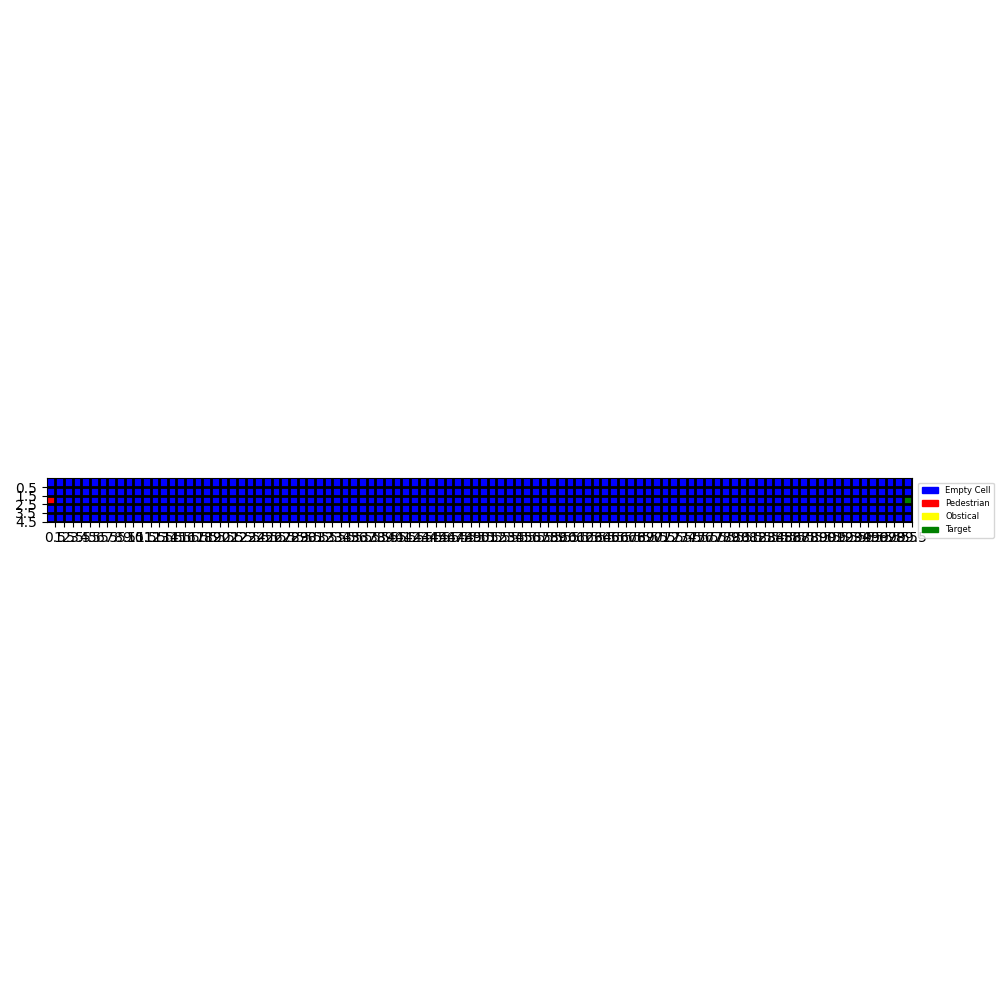

In [11]:
with open('./scenarios/rimea_test1.csv', newline='') as csvfile:
    rimea_1 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_1 = parser_array2obj(rimea_1)
    
cell_scale_meters = 0.4
rimea_1.set_cell_scale(cell_scale_meters)
visualize_state(rimea_1.to_array())

Here we can see the execution of the simulation. In order to see how much time it took for the pedestrian to move from one end to another, we can execute the same simulation with the help of the pygame GUI.

The test case states that if the pedestrian speed is set to 1.33 m/s the simulation should be completed in 26 to 34 seconds. This is because the distance to travel is 40m, hence $t=40/1.33 \approx 30s$. We can simply re-scale this by setting the cell size to 0.4m in our case. Hence the pedestrian speed is $1.33/0.4 = 3.33 cells/second$ and we have $40/0.4 = 100 $ cells then we can expect the pedestrian to reach the target in $t=100/3.33 \approx 30s$. This is very close to what we get from our simulation run when we set the \pythoninline{step\_time} to 300ms (because we set the seconds it takes to move to a cell i.e. $1/3.33 = 0.3s$) which is $\approx 29.7$.


In [ ]:
start_game_gui(rimea_1, max_steps=200, dijkstra=False, step_time=750*cell_scale_meters)

### RiMEA 4

In this scenario, many pedestrians are spread randomly in a grid based on the specified density. Since the scenario is very long (1000m x 10m) and since the pedestrians need to move perpetually we add teleportation boundary conditions such that when pedestrians come at the left end off the grid where the targets exist they are sent back to the initial cells. The scenario becomes a carousel. 

#### Cell Sizing / Scaling
The densities with which the scenario is filled in pedestrians per meter square are 0.5, 1, 2, 3, 4, 5, 6.
This means the cell size needs to be scaled again. In order to fit the largest density, we make the cell size 0.33m such that 1 meter square can cater to a maximum of 9 pedestrians. We can now reduce the size of the grid from an original of 3000 x 30 cells (1000x10 meters) to just 30 x 30 cells (10 x 10 meters).

#### Boundary Conditions
Since the scenario is very long (1000m x 10m) and since the pedestrians need to move perpetually we add periodic boundary conditions such that when pedestrians come at the right end of the grid where the targets exist they are sent back to the initial cells on the left side of the grid if an empty cell is available. The scenario becomes a carousel. We can now reduce the size of the grid from an original of 3000 x 30 cells (1000x10 meters) to just 30 x 30 cells (10 x 10 meters). The entire right strip of the scenario is made the target cells such that all pedestrians move from left to right and are then teleported back to the start in an infinite loop. We terminate the simulation after some number of steps such that our measurements have stabilized.

### Density 0.5 ped/m^2
With a density of 0.5 pedestrians per meter, we notice that in an area of 30/3* 30/3 =  100 meters square we have 100*0.5=50 pedestrians.

We fill the grid randomly with pedestrians.

Adding 49 to the grid.


<IPython.core.display.Javascript object>


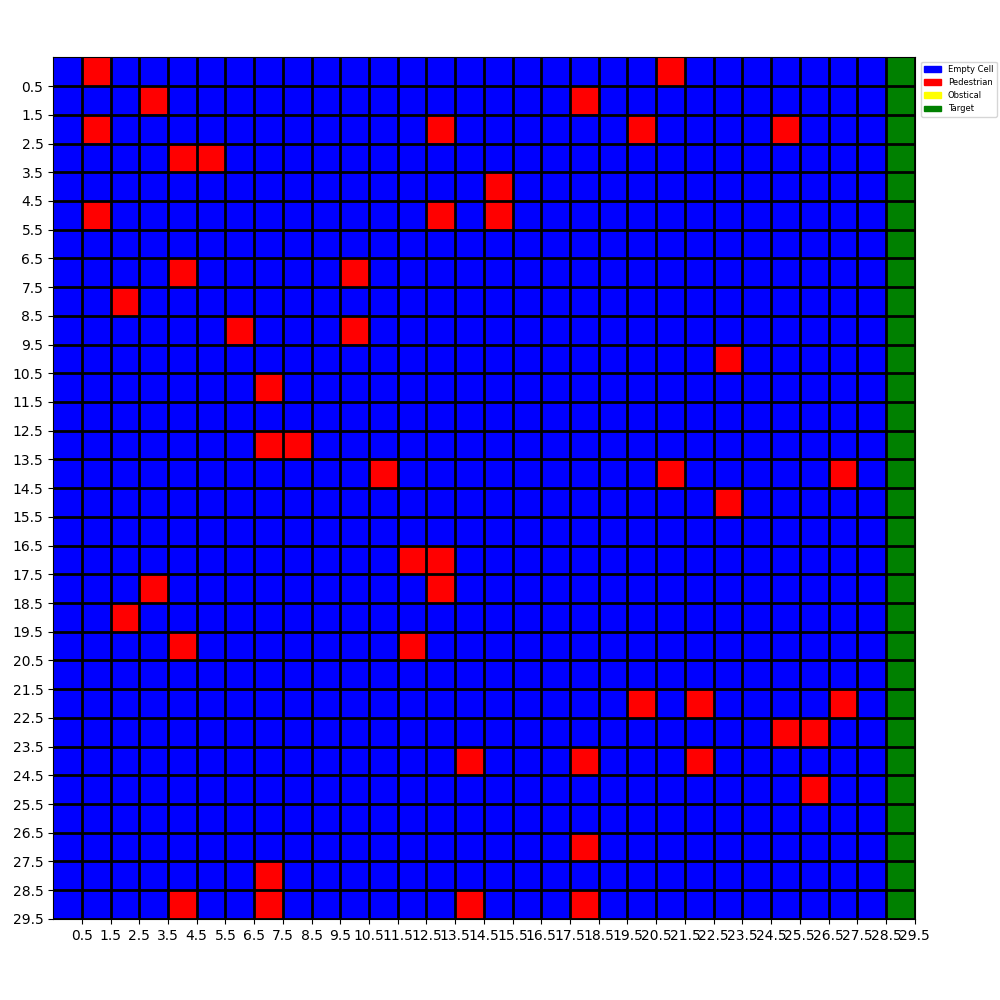

In [12]:
with open('./scenarios/rimea_test4.csv', newline='') as csvfile:
    rimea_4 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_4 = parser_array2obj(rimea_4)

cell_scale_meters = 0.3333
rimea_4.set_cell_scale(0.3333)
rimea_4.flood_pedestrians(0.5)
visualize_state(rimea_4.to_array())

#### Measuring Points

We will set two measuring points which will record the following information:
1. Speed of pedestrian that passed through cell.
2. Density of pedestrians around that point when a pedestrian passed though them.

The grid has an attribute `Grid.measuring_points` where whenever a pedestrian makes a move, it is checked if the pedestrian stepped into one of these points. If so then the pedestrians speed and the local density of the pedestrians in the grid are measured. The speed is measured by storing the last 10 steps of the pedestrian along with the respective time stamp and when the measurement is triggered a simple speed calculation is executed. Similarly for density, the number of pedestrians in the surrounding 10x10 region are taken and divided by the real area (i.e. keeping in mind the scaling of the cell). The data is stored in the form of csv files in the logs folder.

In [ ]:
# Actual Measuring Point
rimea_4.add_measuring_point(15,5)
rimea_4.add_measuring_point(15,6)
rimea_4.add_measuring_point(16,5)
rimea_4.add_measuring_point(16,6)

# Control Point
rimea_4.add_measuring_point(15,20)
rimea_4.add_measuring_point(15,21)
rimea_4.add_measuring_point(16,20)
rimea_4.add_measuring_point(16,21)

# We delete the log file incase it already exists.
if Path("./logs/measuring_points_logs.csv").exists():
    os.remove("logs/measuring_points_logs.csv")

In [ ]:
start_game_gui(rimea_4, max_steps=30, dijkstra=False, step_time=750*cell_scale_meters, periodic_boundary = True)

if Path("./logs/measuring_points_logs.csv").exists():
    copyfile("./logs/measuring_points_logs.csv", "./logs/measuring_points_logs_rimea_4_density0.5.csv")

### Collecting Data for other densities 

In [ ]:
execute_rimea_4()

### Plotting the Fundamental Diagram

We plot the measured speed against the measured density for the 7 different density cases of the RiMEA 4 scenario.

In [14]:
densities_arr = ["0.5", "1","2", "3","4","5","6"]
densities = []
speeds = []
for density in densities_arr:
    file = './logs/measuring_points_logs_rimea_4_density' + density + '.csv'
    df_rimea_4 = pd.read_csv(file)
    df_rimea_4 = df_rimea_4.iloc[-25:]
    df_rimea_4 = df_rimea_4.describe()
    speeds.append(df_rimea_4['speed'].iloc[1])
    densities.append(df_rimea_4['density'].iloc[1])


<IPython.core.display.Javascript object>


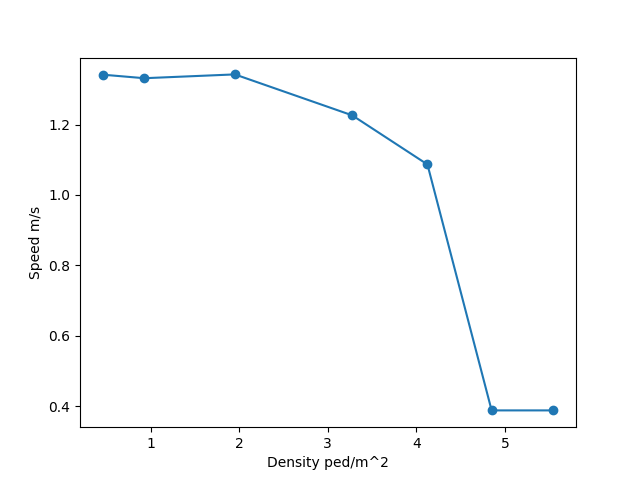

In [15]:
fig, ax = plt.subplots(1,1)
ax.plot(densities, speeds, 'o-')
ax.set_xlabel("Density ped/m^2")
ax.set_ylabel("Speed m/s")
fig.savefig("./figures/fundamental_diagram.pdf")

### RiMEA 6
We simulate the passage of 20 pedestrians around a corner. The pedestrians must navigate while avoiding the obstacle which in this case is the entire wall. In order to match the dimensions in the RiMEA test case, we rescale our cells such that each cell is of length 0.5 meters.

We pack all the pedestrians in the bottom left corner of the scenario as suggested by the test case and the target at the bottom right. The corridor is designed such that we have a large block of obstacles and the only remaining path is then a turn around a corner. It must be ensured that once this scenario is executed, the pedestrians do not move through the obstacles and also do not move over each other. Without obstacles the pedestrians would attempt at moving diagonally as that is the shortest distance but due to the presence of obstacles the pedestrians take the designated path.

<IPython.core.display.Javascript object>


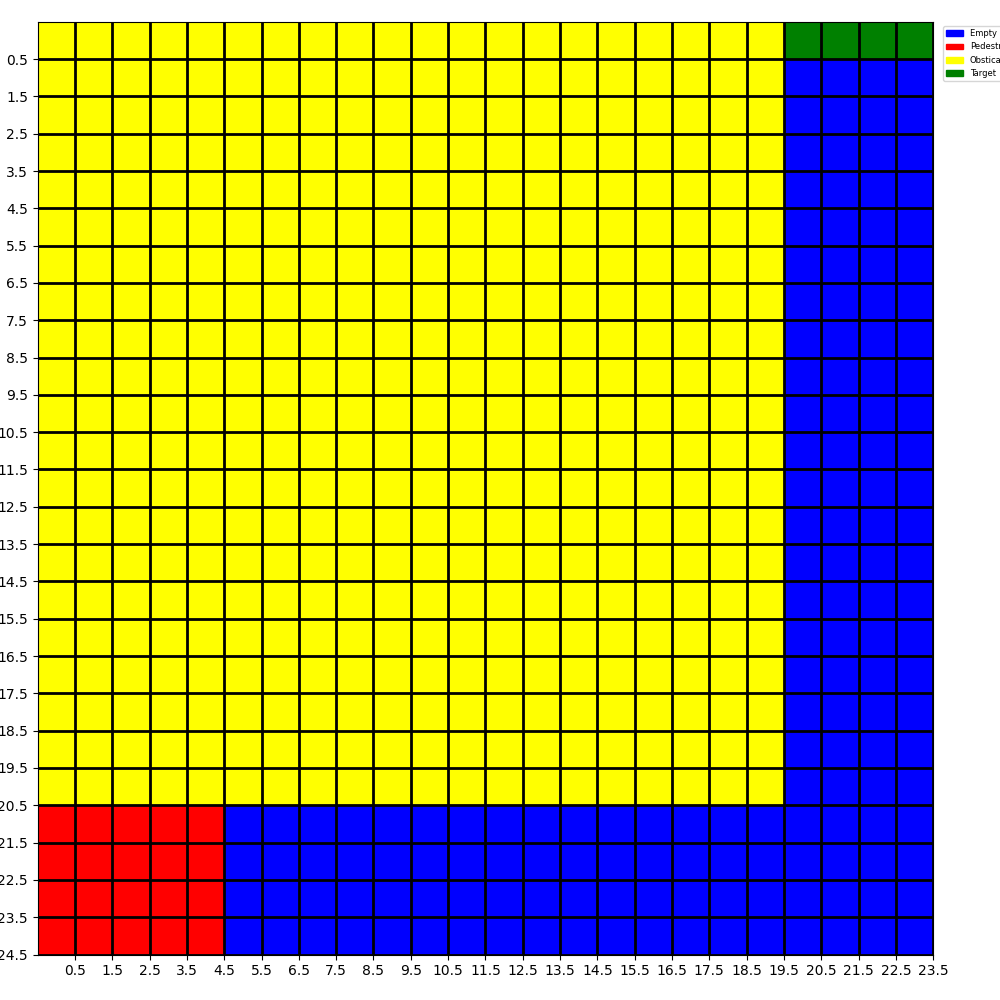

In [16]:
with open('./scenarios/rimea_test6.csv', newline='') as csvfile:
    rimea_6 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_6 = parser_array2obj(rimea_6)
    
cell_scale_meters = 0.5
visualize_state(rimea_6.to_array())

We can observe that the pedestrians can easily navigate around the corner and can also observe the repulsion between pedestrians.

In [ ]:
rimea_6.simulate(35)
rimea_6.animate()

### RiMEA 7

We used some data points from the Figure 2 of the RiMEA guidelines and then used cubic spline interpolation to generate a function that takes the age of the pedestrian as an input and outputs the speed based on the distribtution. We use this function to instantiate 50 pedestrians of random ages and their corresponding speeds and see if we can generate the same distribution as given in the RiMEA guidelines. We build up a 3 x 150 cells (3x150 meters) grid with 3 targets at the right end of the grid. We randomly set 50 pedestrians in the grid and add 9 measuring points.

Whenever a pedestrian moves, their position is checked. If they step into a measuring point then the pedestrian's speed is measured via computing the average speed of their last 10 steps as described before. The data is stored in the form of csv files in the logs folder.



Adding 49 to the grid.


<IPython.core.display.Javascript object>


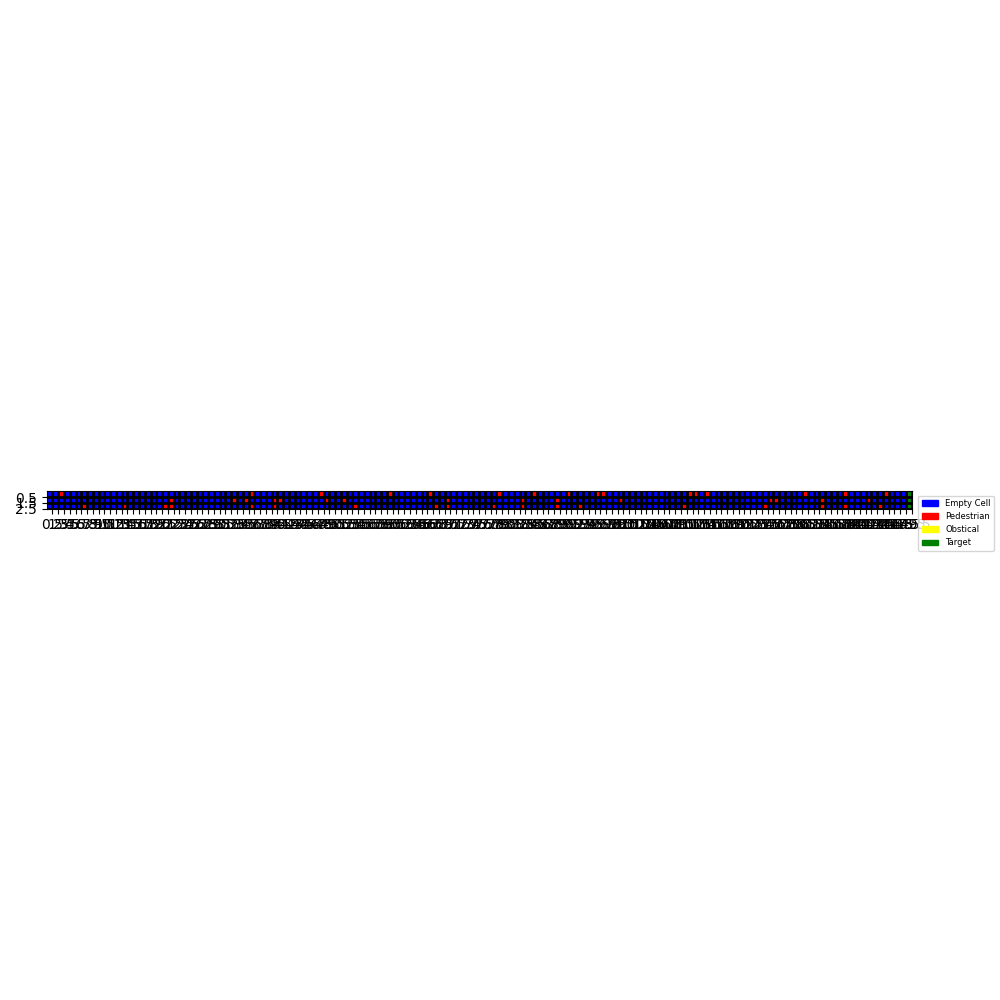

In [17]:
with open('./scenarios/rimea_test7.csv', newline='') as csvfile:
    rimea_7 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_7 = parser_array2obj(rimea_7)
    
rimea_7.flood_pedestrians(0.111, distributed_speed=True)
visualize_state(rimea_7.to_array())

In [ ]:
# Measuring Points
rimea_7.add_measuring_point(0,10)
rimea_7.add_measuring_point(1,10)
rimea_7.add_measuring_point(2,10)
rimea_7.add_measuring_point(0,40)
rimea_7.add_measuring_point(1,40)
rimea_7.add_measuring_point(2,100)
rimea_7.add_measuring_point(0,100)
rimea_7.add_measuring_point(1,100)
rimea_7.add_measuring_point(2,100)
# We delete the log file incase it already exists.
if Path("./logs/measuring_points_logs.csv").exists():
    os.remove("logs/measuring_points_logs.csv")
    
start_game_gui(rimea_7, max_steps=100, dijkstra=False, step_time=1000, periodic_boundary = False, constant_speed = False)

if Path("./logs/measuring_points_logs.csv").exists():
    copyfile("./logs/measuring_points_logs.csv", "./logs/measuring_points_logs_rimea_7.csv")

#### Speed Distribution 

From the scatter diagram, we can see that people of the age 20 walk fastest and with the increase in the age, the speed of a pedestrian goes down. It is consistent with the curve in figure 2 of the RiMEA guidelines.However, there are still some outliers such as a pedestrian at the age of 25 walking with speed 0.0 m/s. This is because some pedestrians are near the measuring points / right at the measuring points when the simulation begins such that we cannot exactly compute their average speeds due to incomplete data.

<IPython.core.display.Javascript object>


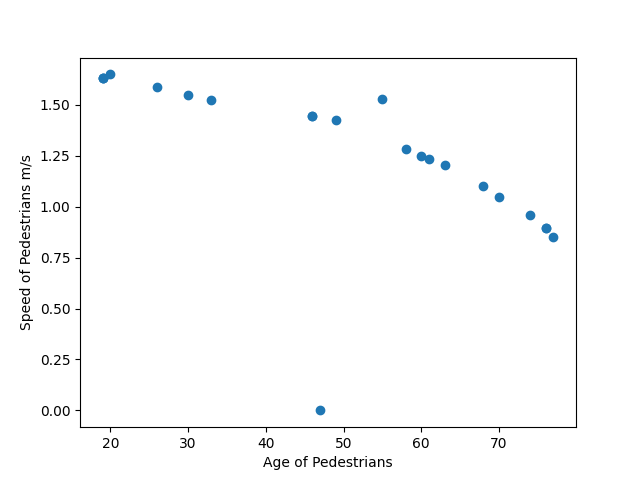

In [18]:
file = './logs/measuring_points_logs_rimea_7.csv'
if Path(file).exists():
    df_rimea_7 = pd.read_csv(file)
    df_rimea_7
    fig, ax = plt.subplots(1,1)
    ax.scatter(df_rimea_7.Pedestrian_Age, df_rimea_7.speed)
    ax.set_xlabel("Age of Pedestrians")
    ax.set_ylabel("Speed of Pedestrians m/s")
    fig.savefig("./figures/age_vs_speed.pdf")
else:
    print(f"logs file {file} does not exist. Run the previous steps first")